In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.2.1+cu121
0.17.1+cu121


In [2]:
from going_modular import data_setup, engine

completed


c:\Users\SHUBHAM\anaconda3\envs\deep_learning\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_setup.create_dataloaders
engine.train_step

<function going_modular.engine.train_step(model: torch.nn.modules.module.Module, dataloader: torch.utils.data.dataloader.DataLoader, loss_fn: torch.nn.modules.module.Module, optimizer: torch.optim.optimizer.Optimizer, device: torch.device) -> Tuple[float, float]>

In [4]:
# device agnostic code

device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 1. Get Data
Download pizza steak sushi data 

In [5]:
from pathlib import Path
import requests
import zipfile
import os

data_path=Path("data/")
image_path=data_path/"pizza_steak_sushi"
if image_path.is_dir():
    print(f"{image_path}  directory already exists..skipping download")
else:
    print(f"{image_path}  directory does not exists exists..creating one")
    os.mkdir(image_path)

with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
    request=requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("downloading the data")
    f.write(request.content)

 # unzipping the file
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
    print("unzipping the file")
    zip_ref.extractall(path=image_path)
    
os.remove(data_path/"pizza_steak_sushi.zip")


data\pizza_steak_sushi  directory already exists..skipping download
downloading the data
unzipping the file


In [6]:
# setup directory path
train_dir=image_path/"train"
test_dir=image_path/"test"
train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

### 2. create dataset and dataloader 
There is one thing we have to think about whern loading: how to **transform** it?
and with 'torchvision' 0.13+ there are two ways to do this:
1. manually created transforms-you decide what transforms you want youre data to go through
2. automatically created transforms -the transforms for the data are defined by the model we would like to use.

### IMPORTANT NOTE: When using pretrained model, it's important that the data (including custom data) that you pass though it is **transformed** in the same way that the data model was trained on.

In [7]:
import torchvision
print(torchvision.__version__)

0.17.1+cu121


### 2.1 Creating a transform for 'torchvision.models' (manual creation)
'torchvision.models' contains the pretrained models(models ready for transfer learning )right within torchvision
all the pre-trained model expect inouts images normalized in the sam way i.e, mini-batches of 3 channnel RGB image of shape (3*H*W), where H and W are expected to be at least 224. the images have to be arranged in [0,1] and then normalized using mean=[0.485,0.456,0.406] and std=[0.229,0.224,0.225]



In [8]:
from torchvision import transforms
from going_modular.data_setup import create_dataloaders
import os


normalize=transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
manual_transforms=transforms.Compose([
                                    transforms.Resize(size=(224,224)),
                                    transforms.ToTensor(),  # [0,1] range
                                    normalize   # make sure images have same distribution as Imagenet (where our pretrained models have been trained)
    ]) 


BATCH_SIZE=32
NUM_WORKERS=os.cpu_count()
train_dataloader, test_dataloader, class_names=create_dataloaders(train_dir=train_dir, test_dir=test_dir, transforms=manual_transforms, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x2baa8c84d40>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for 'torchvision.models' (Auto creation)

As of 'torchvision' v0.13+, there is now support formautomatic data transform creation based on the pretrained model weights you are using.

Before using the pre-trained models, one must preprocess the image (resize with right resolution/interpolation, apply inference transforms, rescale the values etc). There is no standard way to do this as it depends on how a given model was trained. It can vary across model families, variants or even weight versions. Using the correct preprocessing method is critical and failing to do so may lead to decreased accuracy or incorrect outputs.

All the necessary information for the inference transforms of each pre-trained model is provided on its weights documentation. To simplify inference, TorchVision bundles the necessary preprocessing transforms into each model weight. These are accessible via the weight.transforms attribute:

1. Initialize the Weight Transforms
    * weights = ResNet50_Weights.DEFAULT
    * preprocess = weights.transforms()

2. Apply it to the input image
    * img_transformed = preprocess(img)

Some models use modules which have different training and evaluation behavior, such as batch normalization. To switch between these modes, use model.train() or model.eval() as appropriate


3. Initialize model
*   weights = ResNet50_Weights.DEFAULT
*   model = resnet50(weights=weights)

4.  Set model to eval mode
*   model.eval()

In [9]:
import torchvision
print(torchvision.__version__)

0.17.1+cu121


In [10]:
# get a set of pretrained model weights
weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT  # DEFAULT=Best performing weights
weights



EfficientNet_B0_Weights.IMAGENET1K_V1

In [11]:
# Get the transforms used to create our pretrained weights
auto_transforms=weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [12]:
# create dataloaders using automatic transforms
train_dataloader, test_dataloader, class_names=create_dataloaders(train_dir=train_dir, test_dir=test_dir, transforms=auto_transforms, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x2bafee5d5b0>,
 ['pizza', 'steak', 'sushi'])

### 3 getting a pre-trained model

there are various places to get a pretrained model such as;
1. Pytorch domain libraries
2. Libraries like 'timm' (torch image models)
3. HuggingFace Hub ( for plenty different models)
4. paperswithcode


### 3.1 Which pretrained model to use?
Answer--> Experiment, Experimetn, Experiment

the whole idea of transfer learning is : take an already well performing model from a problem space similar to your own an then customizw to your own proble.

Thereee things to consider
1. Speed
2. Size
3. Performance   - how well does it classify (our use case)

Wherer does the model live?
is it on device? (self driving cars)
or does itr live on server?

Looking at https://pytorch.org/vision/0.15/models.html#table-of-all-available-classification-weights 

Which model to choose?
we are choosing model with highest accuracy with with lowest no of parameters
for our case (deoploying FoodVision Mini on mobile device). it looks like 'EffnetB0' is one of our best options in ters of performance vs size


However, in light og=f the Bitter Lesson, if we had infinite compute, we would likely pick the biggest model + most parameters+most general we could
[chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://www.cs.utexas.edu/~eunsol/courses/data/bitter_lesson.pdf](https://www.cs.utexas.edu/~eunsol/courses/data/bitter_lesson.pdf)

### 3.2 setting up a pretrained model
https://pytorch.org/vision/0.15/models/generated/torchvision.models.efficientnet_b0.html#torchvision.models.EfficientNet_B0_Weights


In [13]:
# OLD metrhod of creating a pretrained model (prior to v0.13 )
# model=torchvision.models.efficientnet_b0(pretrained=True)
# new method of creatinf a pretrained model
weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT  # DEFAULT=Best performing weights
model=torchvision.models.efficientnet_b0(weights=weights)
model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\SHUBHAM/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 31.3MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [14]:
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [15]:
model.load_state_dict

<bound method Module.load_state_dict of EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
    

In [16]:
print(model.features)

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [17]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

Kinds of Transfer Learning:
1. original model
2. feature extraction : weights gets frozen and only top 1-3 layers get updated ., small amount of custom data(similar to the model was trained on)
3. finetuning: some or many or all the layers in the pretrained model are updates during trainingbest when we have large amount of training data,

### 3.3 Getting a model summary of our model with 'torchinfo.summary()' 

In [18]:
from torchinfo import summary
summary(model=model,input_size=(32,3,224,224),col_names= (
                "input_size", "output_size", "num_params", "params_percent", "kernel_size", "mult_adds", "trainable",
            ))


Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Param %                   Kernel Shape              Mult-Adds                 Trainable
EfficientNet                                            [32, 3, 224, 224]         [32, 1000]                --                             --                   --                        --                        True
├─Sequential: 1-1                                       [32, 3, 224, 224]         [32, 1280, 7, 7]          --                             --                   --                        --                        True
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]         [32, 32, 112, 112]        --                             --                   --                        --                        True
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]         [32, 32, 112, 112]        864                

For our use case : feature extraction, we want to keep the feature extraction layer weights frozen and only update the weights of heads

### 3.4 Freezing the base layers of our model and updating the classifier head
NOTE : 
with feature extracytion model , typically we will freeze the base layers of our model and update the output layer as per our use case

In [19]:
# freeze all the base layers , we need to update the parameter "required_grad" to false for each parameter

for param in model.features.parameters():
    # print(param)
    param.requires_grad=False


# for confirming print model summary again
    


In [20]:
summary(model=model,input_size=(1,3,224,224),col_names=("input_size", "output_size", "trainable"))
#v trainble---> False

Layer (type:depth-idx)                                  Input Shape               Output Shape              Trainable
EfficientNet                                            [1, 3, 224, 224]          [1, 1000]                 Partial
├─Sequential: 1-1                                       [1, 3, 224, 224]          [1, 1280, 7, 7]           False
│    └─Conv2dNormActivation: 2-1                        [1, 3, 224, 224]          [1, 32, 112, 112]         False
│    │    └─Conv2d: 3-1                                 [1, 3, 224, 224]          [1, 32, 112, 112]         False
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         [1, 32, 112, 112]         False
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         [1, 32, 112, 112]         --
│    └─Sequential: 2-2                                  [1, 32, 112, 112]         [1, 16, 112, 112]         False
│    │    └─MBConv: 3-4                                 [1, 32, 112, 112]         [1,

In [21]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [22]:
# Update the classifier head to suit for our problem
# we need to update the classifier layer
from torch import nn 


# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)
output_shape=len(class_names)
model.classifier=nn.Sequential(nn.Dropout(p=0.2, inplace=True),
                               nn.Linear(in_features=1280, out_features=output_shape, bias=True)).to(device)

model.classifier


Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [23]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

# 4. Train the model


In [34]:
from going_modular.engine import train

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Hyperparameters
lr=0.001
EPOCHS=30
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(lr=lr, params=model.parameters())
torch.manual_seed(42)
torch.cuda.manual_seed(42)
# model.to(device)
results=engine.train(model=model, train_dataloader=train_dataloader, test_dataloader=test_dataloader, optimizer=optimizer,loss_fn=loss_fn, epochs=EPOCHS,device=device )


  3%|▎         | 1/30 [00:20<09:46, 20.24s/it]

Epoch: 1 | train_loss: 0.4393 | train_accuracy: 0.9414 | test_loss: 0.4611 | test_accuracy: 0.8248


  7%|▋         | 2/30 [00:40<09:32, 20.44s/it]

Epoch: 2 | train_loss: 0.3693 | train_accuracy: 0.9648 | test_loss: 0.4426 | test_accuracy: 0.8655


 10%|█         | 3/30 [00:59<08:52, 19.73s/it]

Epoch: 3 | train_loss: 0.3504 | train_accuracy: 0.9375 | test_loss: 0.4605 | test_accuracy: 0.8248


 13%|█▎        | 4/30 [01:18<08:24, 19.42s/it]

Epoch: 4 | train_loss: 0.3916 | train_accuracy: 0.8320 | test_loss: 0.4086 | test_accuracy: 0.8655


 17%|█▋        | 5/30 [01:39<08:14, 19.79s/it]

Epoch: 5 | train_loss: 0.3226 | train_accuracy: 0.9688 | test_loss: 0.4257 | test_accuracy: 0.8352


 20%|██        | 6/30 [01:57<07:44, 19.34s/it]

Epoch: 6 | train_loss: 0.3342 | train_accuracy: 0.9688 | test_loss: 0.4113 | test_accuracy: 0.8352


 23%|██▎       | 7/30 [02:16<07:22, 19.24s/it]

Epoch: 7 | train_loss: 0.3140 | train_accuracy: 0.9570 | test_loss: 0.3944 | test_accuracy: 0.8352


 27%|██▋       | 8/30 [02:36<07:06, 19.40s/it]

Epoch: 8 | train_loss: 0.3294 | train_accuracy: 0.8477 | test_loss: 0.3945 | test_accuracy: 0.8769


 30%|███       | 9/30 [02:54<06:40, 19.09s/it]

Epoch: 9 | train_loss: 0.4486 | train_accuracy: 0.8281 | test_loss: 0.4006 | test_accuracy: 0.8352


 33%|███▎      | 10/30 [03:12<06:14, 18.72s/it]

Epoch: 10 | train_loss: 0.3555 | train_accuracy: 0.8438 | test_loss: 0.3499 | test_accuracy: 0.9062


 37%|███▋      | 11/30 [03:30<05:51, 18.48s/it]

Epoch: 11 | train_loss: 0.2898 | train_accuracy: 0.9727 | test_loss: 0.3741 | test_accuracy: 0.8352


 40%|████      | 12/30 [03:48<05:29, 18.33s/it]

Epoch: 12 | train_loss: 0.3468 | train_accuracy: 0.8555 | test_loss: 0.4179 | test_accuracy: 0.8352


 43%|████▎     | 13/30 [04:06<05:10, 18.28s/it]

Epoch: 13 | train_loss: 0.3097 | train_accuracy: 0.9414 | test_loss: 0.3472 | test_accuracy: 0.8456


 47%|████▋     | 14/30 [04:25<04:56, 18.51s/it]

Epoch: 14 | train_loss: 0.2495 | train_accuracy: 0.9766 | test_loss: 0.3611 | test_accuracy: 0.8561


 50%|█████     | 15/30 [04:44<04:36, 18.44s/it]

Epoch: 15 | train_loss: 0.2376 | train_accuracy: 0.9844 | test_loss: 0.3691 | test_accuracy: 0.8352


 53%|█████▎    | 16/30 [05:01<04:15, 18.23s/it]

Epoch: 16 | train_loss: 0.2566 | train_accuracy: 0.9766 | test_loss: 0.3807 | test_accuracy: 0.8352


 57%|█████▋    | 17/30 [05:19<03:55, 18.14s/it]

Epoch: 17 | train_loss: 0.2300 | train_accuracy: 0.9727 | test_loss: 0.3964 | test_accuracy: 0.8352


 60%|██████    | 18/30 [05:38<03:38, 18.24s/it]

Epoch: 18 | train_loss: 0.2348 | train_accuracy: 0.9648 | test_loss: 0.3813 | test_accuracy: 0.8248


 63%|██████▎   | 19/30 [05:57<03:22, 18.42s/it]

Epoch: 19 | train_loss: 0.2129 | train_accuracy: 0.9609 | test_loss: 0.3912 | test_accuracy: 0.8352


 67%|██████▋   | 20/30 [06:21<03:22, 20.23s/it]

Epoch: 20 | train_loss: 0.3853 | train_accuracy: 0.8555 | test_loss: 0.3957 | test_accuracy: 0.8248


 70%|███████   | 21/30 [06:43<03:07, 20.87s/it]

Epoch: 21 | train_loss: 0.2527 | train_accuracy: 0.9805 | test_loss: 0.3195 | test_accuracy: 0.8456


 73%|███████▎  | 22/30 [07:03<02:43, 20.45s/it]

Epoch: 22 | train_loss: 0.2898 | train_accuracy: 0.8477 | test_loss: 0.3266 | test_accuracy: 0.8456


 77%|███████▋  | 23/30 [07:22<02:21, 20.19s/it]

Epoch: 23 | train_loss: 0.3721 | train_accuracy: 0.8398 | test_loss: 0.3060 | test_accuracy: 0.8561


 80%|████████  | 24/30 [07:44<02:04, 20.74s/it]

Epoch: 24 | train_loss: 0.2618 | train_accuracy: 0.8516 | test_loss: 0.3414 | test_accuracy: 0.8561


 83%|████████▎ | 25/30 [08:06<01:44, 20.91s/it]

Epoch: 25 | train_loss: 0.2843 | train_accuracy: 0.8281 | test_loss: 0.3363 | test_accuracy: 0.8561


 87%|████████▋ | 26/30 [08:26<01:23, 20.84s/it]

Epoch: 26 | train_loss: 0.2969 | train_accuracy: 0.8555 | test_loss: 0.3340 | test_accuracy: 0.8665


 90%|█████████ | 27/30 [08:45<01:00, 20.26s/it]

Epoch: 27 | train_loss: 0.2964 | train_accuracy: 0.8594 | test_loss: 0.3968 | test_accuracy: 0.8352


 93%|█████████▎| 28/30 [09:06<00:40, 20.29s/it]

Epoch: 28 | train_loss: 0.2756 | train_accuracy: 0.8594 | test_loss: 0.3637 | test_accuracy: 0.8456


 97%|█████████▋| 29/30 [09:26<00:20, 20.26s/it]

Epoch: 29 | train_loss: 0.2226 | train_accuracy: 0.9688 | test_loss: 0.3293 | test_accuracy: 0.8665


100%|██████████| 30/30 [09:48<00:00, 19.61s/it]

Epoch: 30 | train_loss: 0.2471 | train_accuracy: 0.9414 | test_loss: 0.3196 | test_accuracy: 0.8561


In [35]:
from going_modular.utils import plot_loss_curves

In [36]:
results.keys()

dict_keys(['train_loss', 'train_accuracy', 'test_loss', 'test_accuracy'])

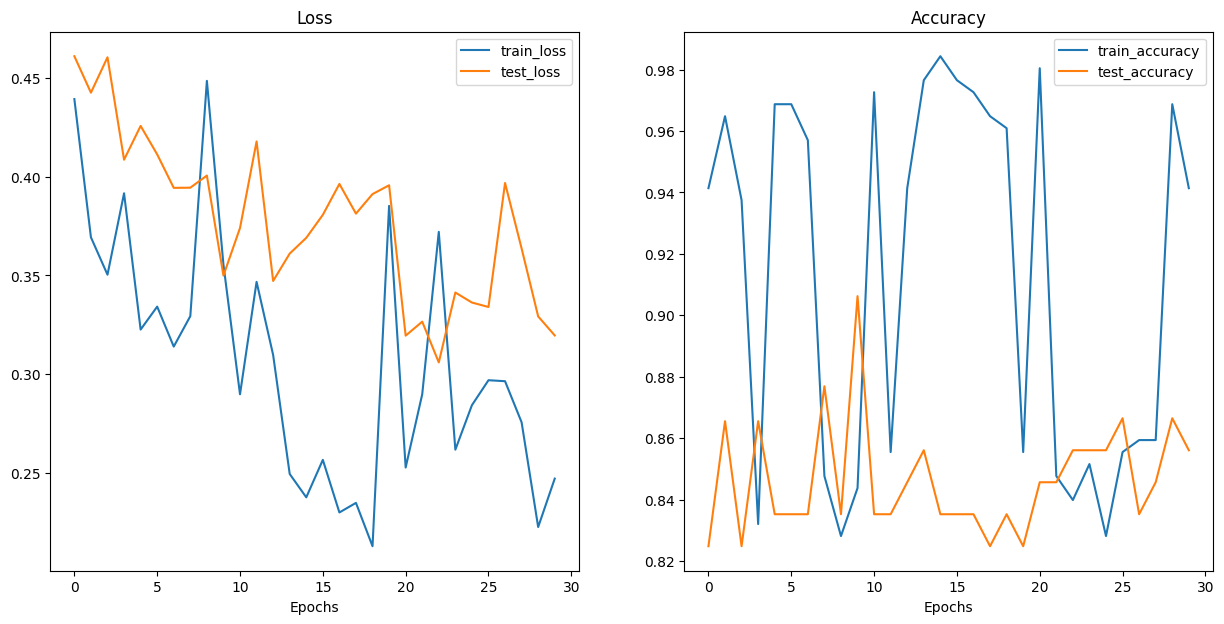

In [37]:
plot_loss_curves(results=results)

In [38]:
from going_modular.utils import save_model
# os.mkdir("models")
model_name="EffNetB0_transferlearning_30_epochs.pth"
save_model(model=model,target_dir="models",model_name=model_name)


[INFO] Saving model to: models\EffNetB0_transferlearning_30_epochs.pth


### Make predictions on images from the test set

One thing we'll have to remember is that for our model to make predictions on an image, the image has to be in same format as the images our model was trained on.

This means we'll need to make sure our images have:

 * Same shape - If our images are different shapes to what our model was trained on, we'll get shape errors.
 * Same datatype - If our images are a different datatype (e.g. torch.int8 vs. torch.float32) we'll get datatype errors.
 * Same device - If our images are on a different device to our model, we'll get device errors.
 * Same transformations - If our model is trained on images that have been transformed in certain way (e.g. normalized with a specific mean and standard deviation) and we try and make preidctions on images transformed in a different way, these predictions may be off.

In [39]:
from typing import List, Tuple
import torch
import torchvision
from PIL import Image
from matplotlib import pyplot as plt
device="cuda" if torch.cuda.is_available() else "cpu"

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

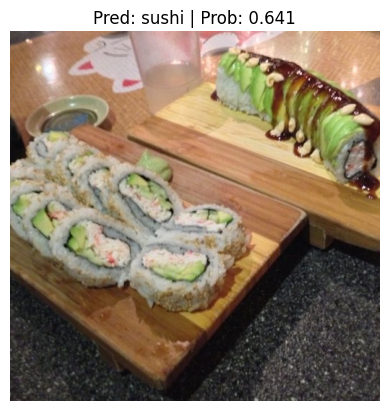

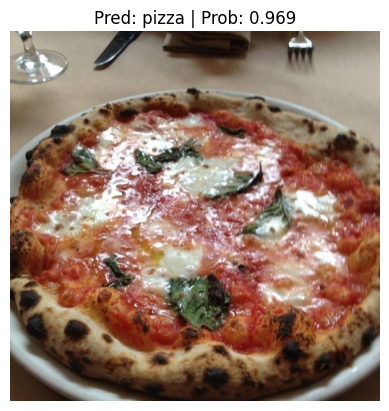

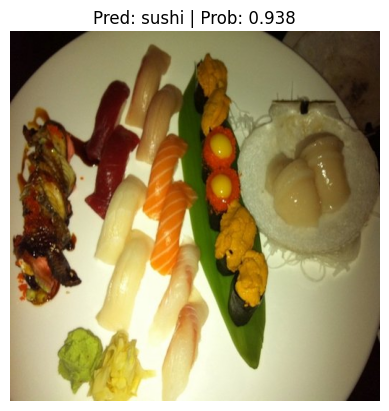

In [40]:
# Get a random list of image paths from test set
from pathlib import Path
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

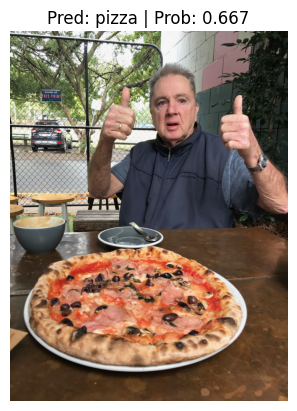

In [42]:
# Download custom image
import requests

# Setup custom image path
# custom_image_path = data_path / "04-pizza-dad.jpeg"
custom_image_path = data_path / "DumpStack.jpeg"


# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

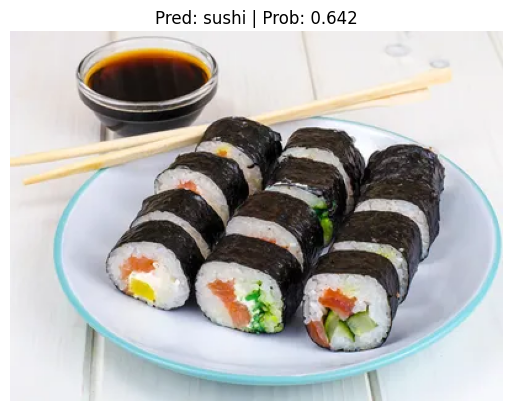

In [44]:
custom_image_path = data_path / "DumpStack.jpg"
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)